In [17]:
import os.path as pth
import pickle as pkl

In [18]:
import pandas as pd

In [158]:
import nibabel as nib

In [38]:
import skimage.morphology

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

In [115]:
def view(vol1, vol2, vol3, slices=8, dim=0):
    assert len(vol1.shape) == 3
    assert vol1.shape[dim] >= slices
    
    def get_slice(vol, slice):
        idx = int(slice * vol.shape[dim] // slices)
        if dim == 0:
            img = vol[idx, :, :]
        elif dim == 1:
            img = vol[:, idx, :]
        elif dim == 2:
            img = vol[:, :, idx]
        return img
    
    for slice in range(slices):
        plt.figure()

        plt.subplot(1, 3, 1)
        plt.axis('off')
        img = get_slice(vol1, slice)
        plt.imshow(img)
        plt.title('ground truth')

        plt.subplot(1, 3, 2)
        plt.axis('off')
        img = get_slice(vol2, slice)
        plt.imshow(img)
        plt.title('dilated ground truth')

        plt.subplot(1, 3, 3)
        plt.axis('off')
        img = get_slice(vol3, slice)
        plt.imshow(img)
        plt.title('border')

# Background mask computation

In [10]:
vis_key_to_cls = {                                                         
    'entire_cls0': 'ET',
    'entire_cls0_neg': 'ET',
    'entire_cls1': 'TC',
    'entire_cls1_neg': 'TC',
    'entire_cls2': 'WT',                                                 
    'entire_cls2_neg': 'WT',
}

In [162]:
layer_key = 'model.0'
vis_key = 'entire_cls0'
base_dir = 'data/models/unet_resize2/an_vis_niftis_entire_cls0_model.0'
afile = pth.join(base_dir, f'analysis.pkl')
if not pth.exists(afile):
    print(f'skipping {afile}')
    #continue
with open(afile, 'rb') as f:
    analysis = pkl.load(f)

vis_name = analysis['vis_name']
layer_name = analysis['layer_name']
examples = []
for ex in analysis['examples']:
    examples.append({
        'id': ex['id'],
        'neg': 'Neg' in vis_name,
        'target_cls': vis_key_to_cls[vis_key],
        'vis_name': vis_name,
        'layer_name': layer_name,
        'vlname': vis_name + ' ' + layer_name,
        'vis_iou_ET': ex['vis_iou'][0, 0],
        'vis_iou_TC': ex['vis_iou'][0, 1],
        'vis_iou_WT': ex['vis_iou'][0, 2],
        #'vis_iou_l1': ex['vis_iou'][0, 3],
        #'vis_iou_l2': ex['vis_iou'][0, 4],
        #'pred_iou_ET': ex['pred_iou'][0, 0],
        #'pred_iou_TC': ex['pred_iou'][0, 1],
        #'pred_iou_WT': ex['pred_iou'][0, 2],
    })
    ex_id = ex['id']
    vis_path = pth.join(base_dir, 'result_dataset',
             ex_id, f'{ex_id}_ET-GradCAM_l1-high-res.nii.gz')
    examples[-1]['vis_path'] = vis_path
    vis = nib.load(vis_path).get_fdata().transpose((3, 0, 1, 2))
    examples[-1]['vis'] = vis

In [225]:
mean_vis = sum(ex['vis'] for ex in examples) / len(examples)

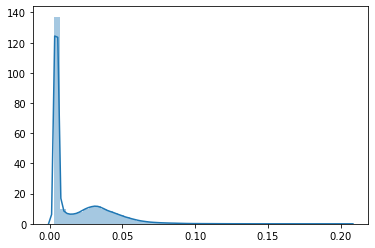

In [226]:
sns.distplot(mean_vis.flatten())

In [238]:
background_mask = (1 - morph.erosion(morph.dilation((mean_vis > 0.01))))[0]

In [240]:
background_mask.shape

(128, 128, 64)

In [244]:
with open('background_mask.pkl', 'wb') as f:
    pkl.dump(background_mask, f)

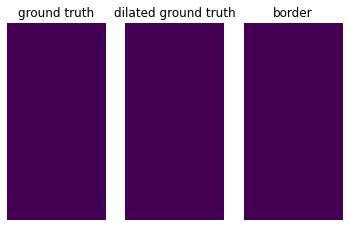

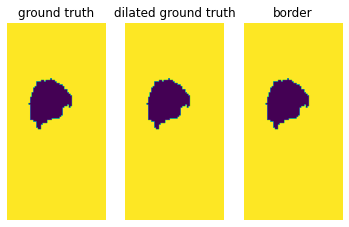

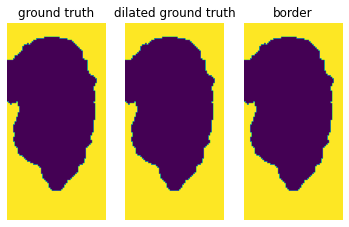

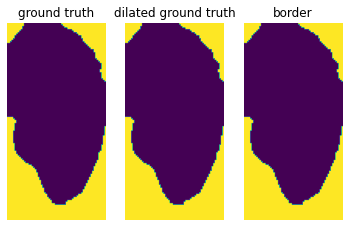

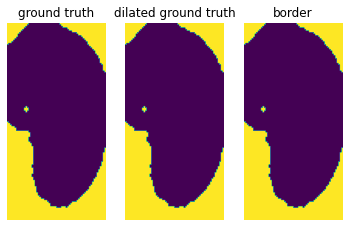

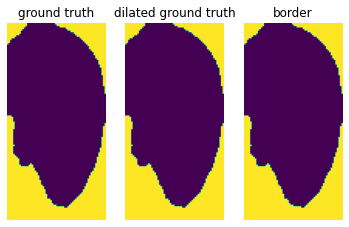

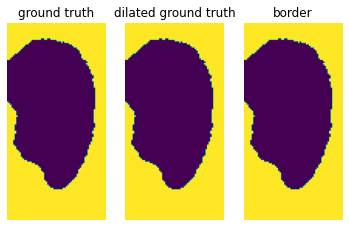

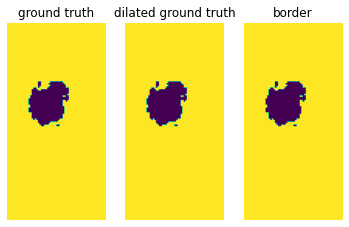

In [241]:
view(background_mask, background_mask, background_mask, dim=0)

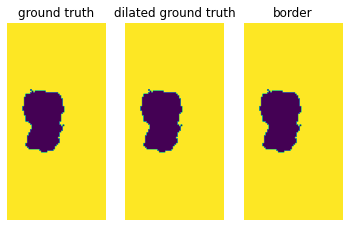

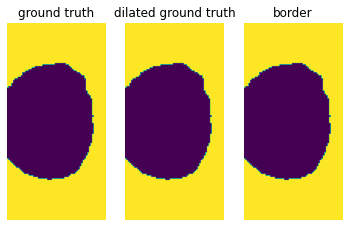

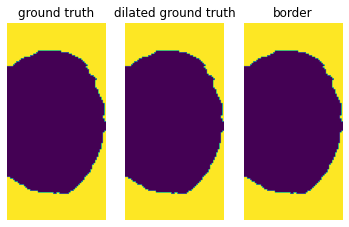

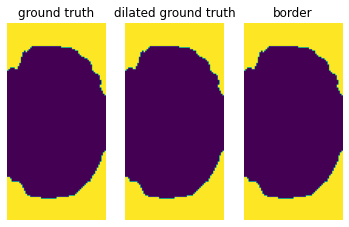

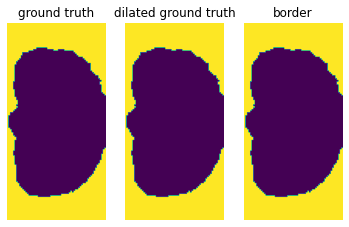

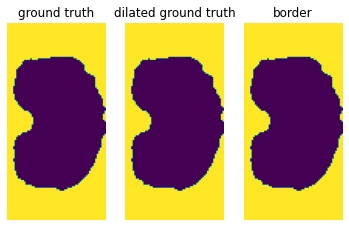

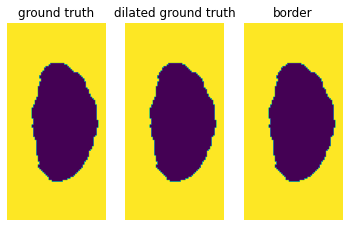

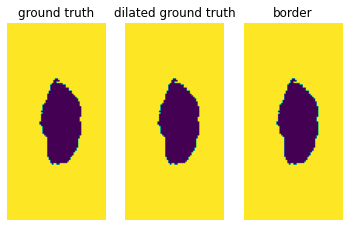

In [242]:
view(background_mask, background_mask, background_mask, dim=1)

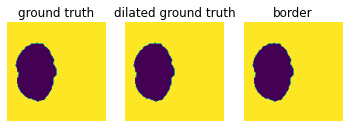

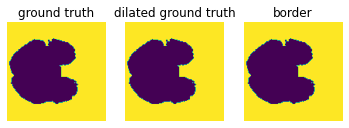

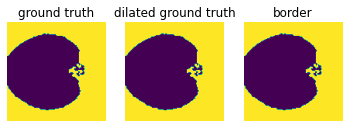

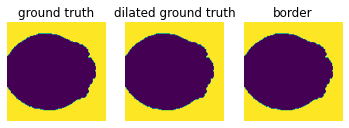

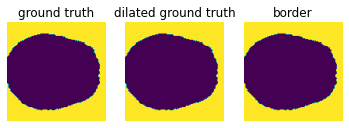

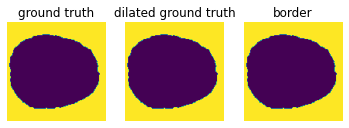

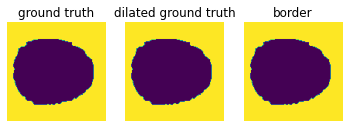

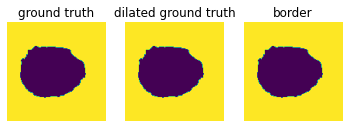

In [243]:
view(background_mask, background_mask, background_mask, dim=2)

# Dilation examples

In [24]:
import options
args = options.parser.parse_args(args=['dummy_model_dir'])

In [27]:
from data_utils import load_data

In [28]:
train_ds, train_loader, val_ds, val_loader = load_data(args)

281/281 Load and cache transformed data:  [==============================]
88/88 Load and cache transformed data:  [==============================]


In [245]:
def find_border(seg):
    result = morph.dilation(seg, morph.cube(3))
    return np.maximum(0, result - seg)

In [247]:
ex = train_ds[2]

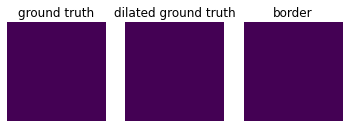

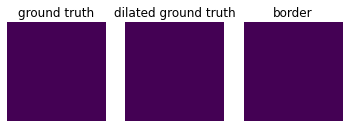

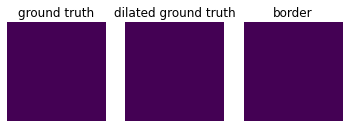

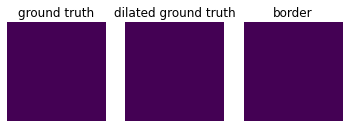

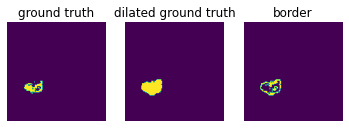

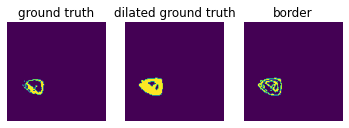

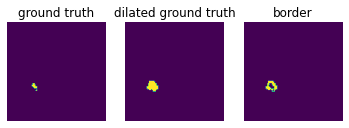

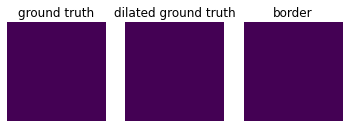

In [248]:
ipt = ex['seg'][0].numpy()
result = skimage.morphology.dilation(ipt, skimage.morphology.cube(3))
view(ipt, result, find_border(ipt), dim=2)

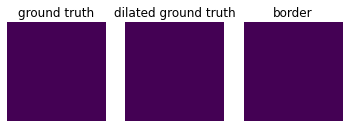

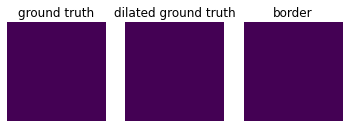

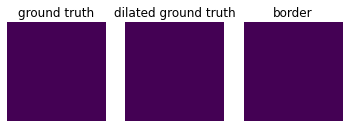

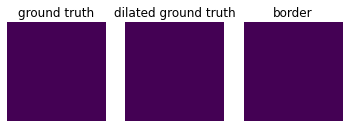

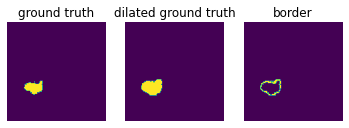

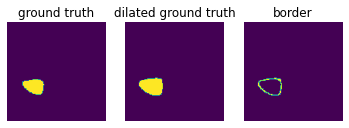

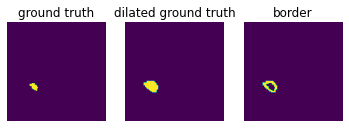

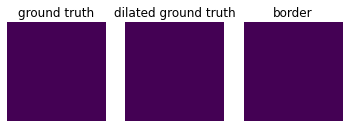

In [250]:
ipt = ex['seg'][1].numpy()
result = skimage.morphology.dilation(ipt, skimage.morphology.cube(3))
view(ipt, result, find_border(ipt), dim=2)

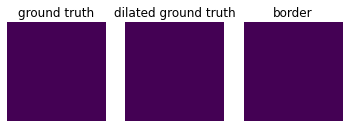

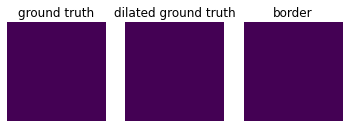

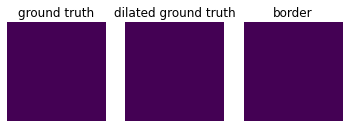

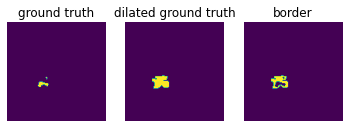

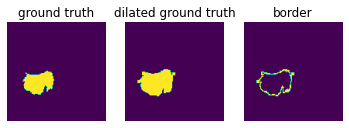

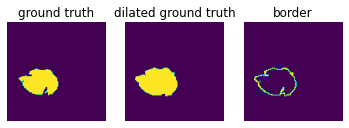

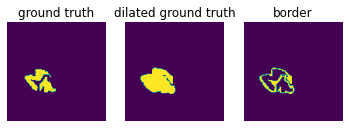

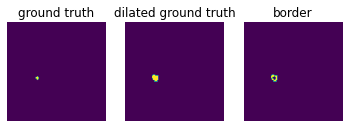

In [251]:
ipt = ex['seg'][2].numpy()
result = skimage.morphology.dilation(ipt, skimage.morphology.cube(3))
view(ipt, result, find_border(ipt), dim=2)